# Neural Network

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('nn_train.csv')
test_data = pd.read_csv('nn_test.csv')

In [9]:
X = data.iloc[:, 1:-2].values  
X_test = test_data.iloc[:, 1:].values 
binary_labels = data.iloc[:, -2].values 
class_labels = data.iloc[:, -1].values 

In [10]:
def normalize(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

X = normalize(X)

In [11]:
class_labels -= np.min(class_labels)

 One-hot encode class labels

In [13]:
num_classes = len(np.unique(class_labels))
class_labels_one_hot = np.zeros((len(class_labels), num_classes))
for i, label in enumerate(class_labels):
    class_labels_one_hot[i, label] = 1

 Activation functions

In [15]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

Loss functions

In [17]:
def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

def cross_entropy_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

In [18]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights1 = np.random.randn(input_size, hidden_size) * 0.01
        self.bias1 = np.zeros((1, hidden_size))
        self.weights2 = np.random.randn(hidden_size, output_size) * 0.01
        self.bias2 = np.zeros((1, output_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        return self.z2

    def backward(self, X, y, y_pred, lr, task):
        m = X.shape[0]

        if task == "binary":
            dz2 = y_pred - y
        else:
            dz2 = y_pred - y

        dw2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        da1 = np.dot(dz2, self.weights2.T)
        dz1 = da1 * relu_derivative(self.z1)
        dw1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.weights1 -= lr * dw1
        self.bias1 -= lr * db1
        self.weights2 -= lr * dw2
        self.bias2 -= lr * db2

    def train(self, X, y, epochs, lr, task):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            
            if task == "binary":
                y_pred = sigmoid(y_pred)
                loss = binary_cross_entropy(y, y_pred)
            else:
                y_pred = softmax(y_pred)
                loss = cross_entropy_loss(y, y_pred)

            self.backward(X, y, y_pred, lr, task)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X, task):
        y_pred = self.forward(X)
        if task == "binary":
            return (sigmoid(y_pred) > 0.5).astype(int)
        else:
            return np.argmax(softmax(y_pred), axis=1)

In [19]:
X_test = normalize(X_test)

In [20]:
binary_nn = NeuralNetwork(input_size=X.shape[1], hidden_size=64, output_size=1)
binary_nn.train(X, binary_labels.reshape(-1, 1), epochs=500, lr=0.3, task="binary")

binary_predictions = binary_nn.predict(X, task="binary")
binary_predictions = np.ravel(binary_predictions)

Epoch 0, Loss: 0.6926
Epoch 100, Loss: 0.7647
Epoch 200, Loss: 0.5270
Epoch 300, Loss: 0.5167
Epoch 400, Loss: 0.5052


In [21]:
class_nn = NeuralNetwork(input_size=X.shape[1], hidden_size=64, output_size=num_classes)
class_nn.train(X, class_labels_one_hot, epochs=500, lr=0.3, task="class")

class_predictions = class_nn.predict(X, task="class")

Epoch 0, Loss: 2.3025
Epoch 100, Loss: 1.7092
Epoch 200, Loss: 1.5952
Epoch 300, Loss: 1.5569
Epoch 400, Loss: 1.4786


In [22]:
binary_predictions_test = binary_nn.predict(X_test, task="binary")
class_predictions_test = class_nn.predict(X_test, task="class")

In [23]:
output_df = pd.DataFrame({
    "id": test_data.iloc[:, 0], 
    "binary_label": binary_predictions_test.flatten(), 
    "class_label": class_predictions_test
})

print(output_df.head())

   id  binary_label  class_label
0   1             1            2
1   2             0            8
2   3             0            8
3   4             0            1
4   5             1            2


In [24]:
def f1_score_binary(y, y_pred):
    tp = np.sum((y == 1) & (y_pred == 1))
    fp = np.sum((y == 0) & (y_pred == 1))
    fn = np.sum((y == 1) & (y_pred == 0))

    precision = tp / max(tp + fp, 1) 
    recall = tp / max(tp + fn, 1) 

    f1 = 2 * (precision * recall) / max(precision + recall, 1e-8)
    return f1
binary_f1_score = f1_score_binary(binary_labels, binary_predictions)
print(f"Binary F1 Score: {binary_f1_score:.4f}")


Binary F1 Score: 0.7556


In [25]:
def f1_score_class(y_true, y_pred):
    unique_classes = np.unique(y_true)
    f1_scores = []
    class_f1_scores = {}  # To store F1 score for each class
    weights = []

    for cls in unique_classes:
        cls_y_true = (y_true == cls).astype(int)
        cls_y_pred = (y_pred == cls).astype(int)
        
        tp = np.sum((cls_y_true == 1) & (cls_y_pred == 1))  # True positives
        fp = np.sum((cls_y_true == 0) & (cls_y_pred == 1))  # False positives
        fn = np.sum((cls_y_true == 1) & (cls_y_pred == 0))  # False negatives
        
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        
        class_f1_scores[cls] = f1  
        f1_scores.append(f1)

        weights.append(np.sum(cls_y_true))
    
    weighted_f1 = np.sum(np.array(f1_scores) * np.array(weights)) / np.sum(weights)
    
    return class_f1_scores, weighted_f1

class_f1_scores, weighted_f1 = f1_score_class(class_labels, class_predictions)

print(f"Class-wise F1 Scores: {class_f1_scores}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")


Class-wise F1 Scores: {0: 0.5072861619275809, 1: 0.6312308289913959, 2: 0.47461655512179807, 3: 0.43590619590669544, 4: 0.5182208472106994, 5: 0.3958303121915401, 6: 0.49687873058119814, 7: 0.5294589375649121, 8: 0.570245212291288, 9: 0.5699076539717433}
Weighted F1 Score: 0.5129


In [26]:
output_file_path = 'nn_test_pred.csv'
output_df.to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")


Predictions saved to nn_test_pred.csv


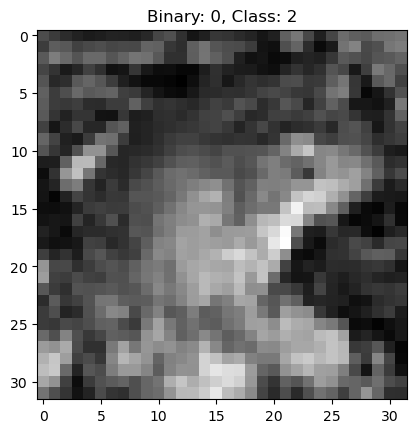

In [77]:
sample_index = 0
sample_image = X_test[sample_index].reshape(int(np.sqrt(X.shape[1])), -1) 
plt.imshow(sample_image, cmap='gray')
plt.title(f"Binary: {binary_predictions[sample_index]}, Class: {class_predictions[sample_index]}")
plt.show()

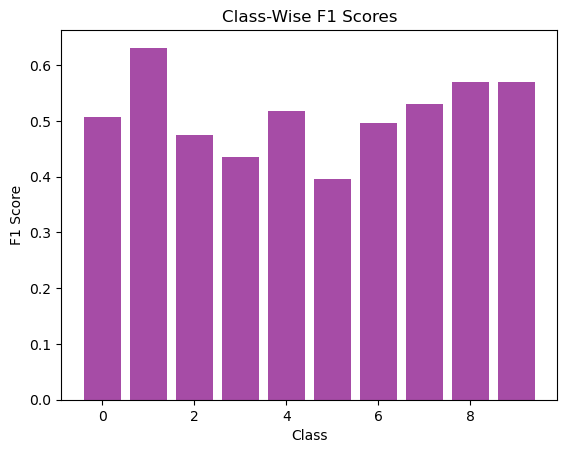

In [28]:
plt.bar(class_f1_scores.keys(), class_f1_scores.values(), color='purple', alpha=0.7)
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.title("Class-Wise F1 Scores")
plt.show()


               Pred Negative  Pred Positive
True Negative          31239           8761
True Positive          10393          29607


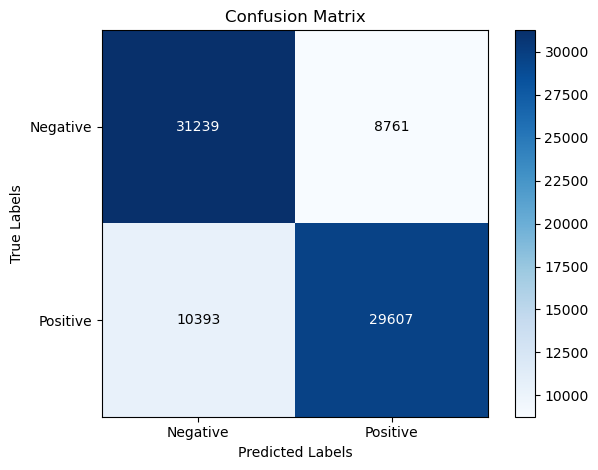

In [87]:
def confusion_matrix(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=int)
    
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    
    return cm

cm = confusion_matrix(binary_labels, binary_predictions)

cm_df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Pred Negative', 'Pred Positive'])
print(cm_df)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.tight_layout()
plt.show()

Confusion Matrix:
                Pred Negative  Pred Positive
True Negative          31239           8761
True Positive          10393          29607
Accuracy: 0.7606
Precision: 0.7717
Recall: 0.7402
F1 Score: 0.7556


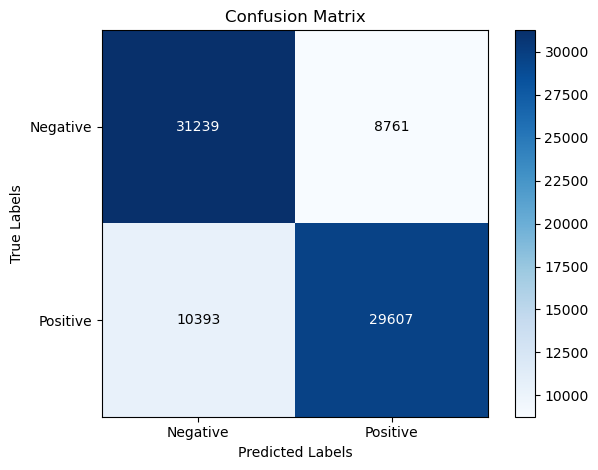

In [89]:
TN = 31239
FP = 8761
FN = 10393
TP = 29607

cm = np.array([[TN, FP],
               [FN, TP]])

cm_df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Pred Negative', 'Pred Positive'])
print("Confusion Matrix:\n", cm_df)

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
plt.tight_layout()
plt.show()
